# Single Harmonic
This looks at how much information can be extracted about the seasonal cycle, restricting ourselves to a single harmonic.

In [1]:
import copy
import sys
import os

from isca_tools.utils.xarray import wrap_with_apply_ufunc, update_dim_slice, transpose_common_dims_like

# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import clausius_clapeyron_factor, sphum_sat, get_density
from isca_tools.utils.constants import kappa, L_v, c_p, c_p_water, rho_water, Stefan_Boltzmann, R, R_v
from isca_tools.utils import numerical
from isca_tools.utils.radiation import get_heat_capacity
from isca_tools.plot import colored_line
from isca_tools.thesis.surface_energy_budget import get_temp_fourier_analytic, get_temp_fourier_numerical, \
    get_temp_extrema_analytic, get_param_dimensionless
from isca_tools.utils.fourier import fourier_series
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from tqdm.notebook import tqdm
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig, label_subplots

import jobs.thesis_season.thesis_figs.utils as utils

# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']

In [2]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 't_surf', 'swdn_sfc', 'lwup_sfc', 'lwdn_sfc',
            'flux_lhe', 'flux_t', 'drag_q', 'q_surf', 'ps', 'q_surf', 'w_atm', 'q_atm']
# Load dataset
exp_dir = lambda x, y=False: f'thesis_season/depth={x}/k=1_const_drag{"_evap=0_1" if y else ""}'
exp_name = [exp_dir(5), exp_dir(20)]


def get_p(ds):
    return ds.ps * ds.hybm


# Get low level sigma level
namelist = isca_tools.load_namelist(exp_name[0])
p_surface_approx = namelist['spectral_dynamics_nml']['reference_sea_level_press'] / 100
sigma_levels_half = np.asarray(namelist['vert_coordinate_nml']['bk'])
sigma_levels_full = np.convolve(sigma_levels_half, np.ones(2) / 2, 'valid')
# sigma_near_surf = sigma_levels_full[-1]

n_exp = len(exp_name)
# Think best to use one hemisphere as from Roach expect slight difference between hemispheres
ax_lims_lat = [30, 90]
lat_range = slice(ax_lims_lat[0],
                  ax_lims_lat[
                      1])  # only consider NH and outside deep tropics, and ignore high latitudes as need 2nd harmonic there
ds_base = []
for i in tqdm(range(n_exp)):
    ds_use = isca_tools.load_dataset(exp_name[i], first_month_file=121)
    try:
        ds_use = ds_use[var_keep]
    except KeyError:
        remove_keys = []
        for key in var_keep:
            if key not in ds_use:
                print(f'Removing {key} from var_keep')
                remove_keys += [key]
        for key in remove_keys:
            var_keep.remove(key)
        ds_use = ds_use[var_keep]
    ds_use = ds_use.sel(lat=lat_range)
    ds_use['hybm'] = ds_use.temp.isel(time=0, lat=0, lon=0) * 0 + sigma_levels_full
    ds_use = ds_use.sel(pfull=np.inf, method='nearest')  # only keep lowest level
    # Compute variables required for flux breakdown
    ds_use['emission_factor'] = ds_use.lwdn_sfc / (Stefan_Boltzmann * ds_use.temp ** 4)
    ds_use['temp_diseqb'] = ds_use.t_surf - ds_use.temp
    ds_use['rh'] = ds_use.q_atm / sphum_sat(ds_use.temp, get_p(ds_use))
    ds_use['lw_net'] = ds_use.lwup_sfc - ds_use.lwdn_sfc
    ds_use['flux_net'] = ds_use['lw_net'] + ds_use['flux_lhe'] + ds_use['flux_t']
    ds_base += [ds_use.load()]  # only keep after spin up
mixed_layer_depth = [isca_tools.load_namelist(exp_name[i])['mixed_layer_nml']['depth'] for i in range(n_exp)]
mixed_layer_depth = xr.DataArray(mixed_layer_depth, dims="depth", name='depth')
ds_base = xr.concat(ds_base, dim=mixed_layer_depth)
ds_base['heat_capacity'] = get_heat_capacity(c_p_water, rho_water, ds_base.depth)
ds_base['hybm'] = ds_base.hybm.isel(depth=0)
ds_base = ds_base.rename_vars({'temp': 't_atm'})
# ds_base.attrs['drag_const'] = isca_tools.load_namelist(exp_name[0])['surface_flux_nml']['drag_const']

  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
ds = utils.get_annual_zonal_mean(ds_base)
f = 1/(ds.time.size*utils.day_seconds)

## Empirical fitting
Here we find the empirical parameters in the approximation for $\Gamma^{\uparrow} = (LW^{\uparrow} - LW^{\downarrow}) - LH^{\uparrow} - SH^{\uparrow}$ which are completely independent of the number of harmonics used in the solving of the surface energy budget. We just find the parameters $\lambda_0$, $\lambda$, $\lambda_{phase}$, $\lambda_{sq}$, $\Lambda_{cos}$, and $\Lambda_{sin}$ such that:

$$
\Gamma^{\uparrow} \approx \lambda_0 + \frac{1}{2}\lambda_{phase}(T(t-\mathcal{T}/4) - T(t+\mathcal{T}/4)) +
\lambda T(t) + \lambda_{sq} T'^{2}(t) + \Lambda_{cos}\\cos(4\pi t/\mathcal{T}) +
\Lambda_{sin}\sin(4\pi t/\mathcal{T})
$$

where $T' = T(t) - \overline{T}$ is the surface temperature anomaly and $\mathcal{T}$ is the period i.e. one year.

Note that if $\lambda_{sq}$ is not zero, $\lambda$ and $\lambda_0$ will change values from the case where $\lambda_{sq}=0$; a result that is just due to the normal behaviour of ploynomaial fitting i.e., `np.polyfit`.

### Solution for $T$
Given this approximation, we can then seek an analytical expression for the temperature (exact solution if $\lambda_{sq}=0$). This is where our constraint in this notebook of choosing one harmonic comes in. Given this choice, we set $\lambda_{sq} = \Lambda_{cos} = \Lambda_{sin} = 0$ when solving the differential equation as these parameters have no effect on the single harmonic solution.

In [4]:
n_harmonics = xr.DataArray([1, 2, 5], dims="n_harmonics", name='n_harmonics')
# List all fitting methods for this case. Only 1 harmonic in this notebook, so only include linear and linear_phase
fit_method = xr.DataArray(['simulated', 'direct1', 'direct2', 'direct5', 'linear', 'linear_phase'], name='fit_method',
                          dims='fit_method')
fit_method = fit_method.assign_coords(fit_method=fit_method.values)

sw_amp_coefs = {}
sw_fourier_fit = []
temp_anom_fit = [ds.t_surf]
# temp_anom_fourier_fit = {key: np.zeros((n_lat, n_time)) for key in ['1_harmonic', '2_harmonic', '5_harmonic']}
for key in n_harmonics.values:
    sw_amp_coefs[key] = utils.get_fourier_fit_xr(ds.time, ds.swdn_sfc, n_harmonics=key, pad_coefs_phase=True)[1]
    # Fit SW fourier with no phase
    sw_fourier_fit.append(utils.fourier_series_xr(ds.time, sw_amp_coefs[key], np.zeros(key + 1), pad_coefs_phase=True))
    temp_anom_fit.append(utils.get_fourier_fit_xr(ds.time, ds.t_surf, n_harmonics=key, pad_coefs_phase=True)[0])
sw_fourier_fit = xr.concat(sw_fourier_fit, dim=n_harmonics)
sw_fourier_fit = transpose_common_dims_like(sw_fourier_fit, ds.swdn_sfc)

temp_anom_fit = xr.concat(temp_anom_fit,
                          dim=fit_method.sel(fit_method=[key for key in fit_method.values if 'linear' not in key]))
temp_anom_fit = temp_anom_fit - temp_anom_fit.mean(dim='time')
temp_anom_fit = temp_anom_fit.reindex(fit_method=fit_method, fill_value=0)
temp_anom_fit = temp_anom_fit.transpose('fit_method', 'depth', 'lat', 'time')


In [5]:
# Initialize Surface upward flux; so can add approximations later
fit_method_flux = xr.DataArray(
    ['simulated', 'linear', 'linear_phase', 'square_phase', 'square_phase+', 'poly10_phase+'],
    name='fit_method', dims='fit_method')
fit_method_flux = fit_method_flux.assign_coords(fit_method=fit_method_flux.values)
surf_flux_up = ds[['flux_lhe', 'flux_t']] * 0
surf_flux_up['lw'] = (ds.lwup_sfc - ds.lwdn_sfc) * 0
surf_flux_up = surf_flux_up.expand_dims(fit_method=fit_method_flux)
surf_flux_up = surf_flux_up.copy(deep=True)  # so can update variables
surf_flux_up = transpose_common_dims_like(surf_flux_up, temp_anom_fit)

for key in surf_flux_up:
    # Simulated
    surf_flux_up = update_dim_slice(surf_flux_up, 'fit_method', 'simulated',
                                    ds.lwup_sfc - ds.lwdn_sfc if key == 'lw' else ds[key], key)
    # Best possible 10 polynomial fit with fourier and phase
    key2 = 'poly10_phase+'
    # Don't save fitting variables, as has deg is much larger so mismatch of dimensions
    var = utils.polyfit_phase_xr(temp_anom_fit.sel(fit_method='simulated'),
                                 surf_flux_up[key].sel(fit_method='simulated'), deg=10,
                                 include_phase='phase' in key2, include_fourier='+' in key2)
    var = utils.polyval_phase_xr(var, temp_anom_fit.sel(fit_method='simulated'))
    surf_flux_up = update_dim_slice(surf_flux_up, 'fit_method', key2, var, key)

surf_flux_up = surf_flux_up.rename_vars({'flux_lhe': 'lh', 'flux_t': 'sh'})
surf_flux_up['net'] = surf_flux_up['lh'] + surf_flux_up['sh'] + surf_flux_up['lw']


# Sanity check that smoothed sum of fluxes (flux_net) matches sum of smoothed fluxes (surf_flux_up['net'])
var = ds['flux_net'] - surf_flux_up['net'].sel(fit_method='simulated')
var = float(np.abs((var / np.abs(surf_flux_up['net'].sel(fit_method='simulated')))).fillna(0).max() * 100)  # percentage error
if var > 0.1:
    raise ValueError(f"Smoothed sum of fluxes differs sum of smoothed fluxes by more than 0.1% from params fit to sum")


# Initialize parameters used to fit the individual fluxes in surf_flux_up
surf_flux_up_params = (surf_flux_up * 0).sel(fit_method=[key for key in fit_method_flux.values if key
                                                         not in ['simulated', 'poly10_phase+']]).isel(time=0, drop=True)
surf_flux_up_params = surf_flux_up_params.expand_dims({'deg': utils.deg_vals})
surf_flux_up_params = surf_flux_up_params.transpose('fit_method', 'lat', 'depth', 'deg')
surf_flux_up_params = surf_flux_up_params.copy(deep=True)
surf_flux_up_params = transpose_common_dims_like(surf_flux_up_params, temp_anom_fit)

# Compute params for each individual flux for both the linear and linear phase mechanisms
for key in surf_flux_up_params:
    for key2 in surf_flux_up_params.fit_method.values:
        if key2 == 'poly10_phase+':
            continue
        var = utils.polyfit_phase_xr(temp_anom_fit.sel(fit_method='simulated'),
                                     surf_flux_up[key].sel(fit_method='simulated'), deg=2 if 'square' in key2 else 1,
                                     include_phase='phase' in key2, include_fourier='+' in key2)
        surf_flux_up_params = update_dim_slice(surf_flux_up_params, 'fit_method', key2, var, key)
        var = utils.polyval_phase_xr(surf_flux_up_params[key].sel(fit_method=key2),
                                     temp_anom_fit.sel(fit_method='simulated'))
        surf_flux_up = update_dim_slice(surf_flux_up, 'fit_method', key2, var, key)

# Sanity check that the sum of individual params equals the params fit to the sum
var = surf_flux_up_params['lw'] + surf_flux_up_params['lh'] + surf_flux_up_params['sh'] - surf_flux_up_params['net']
var = float(np.abs((var / np.abs(surf_flux_up_params['net']))).fillna(0).max() * 100)  # percentage error
if var > 0.1:
    raise ValueError(f"Sum of params differs by more than 0.1% from params fit to sum")

# Get temp approximations for linear and linear_phase
for key in ['linear', 'linear_phase']:
    var = utils.get_temp_fourier_analytic_xr(ds.time, ds.swdn_sfc, ds.heat_capacity,
                                             surf_flux_up_params['net'].sel(fit_method=key),
                                             n_harmonics=1)[0]
    temp_anom_fit = update_dim_slice(temp_anom_fit, 'fit_method', key, var)

In [6]:
# Sanity check that lambda_0 and lambda take different values if include lambda_sq or not
print('Example fitting params')
for key in surf_flux_up_params.fit_method.values:
    print(key, np.round(surf_flux_up_params.isel(depth=0, lat=-1).lh.sel(fit_method=key).values, 3))

Example fitting params
linear [ 0.     0.     0.     0.     0.716 12.523]
linear_phase [-0.036  0.     0.     0.     0.716 12.523]
square_phase [-0.036  0.     0.     0.021  0.61   2.483]
square_phase+ [-0.036  1.548  0.127  0.022  0.599  2.091]


## How many harmonics required?
Here we look fit a fourier expansion of a given number of harmonics directly to the temperature and shortwave radiation. It seems that there is a large reduction in error as we go from 1 to 2 harmonics, but not much more is gained by including more than 2 harmonics.

The surface energy budget is
$$
C\frac{\partial T}{\partial t} = SW^{\downarrow} - (LW^{\uparrow} - LW^{\downarrow}) - LH^{\uparrow} - SH^{\uparrow}
= SW^{\downarrow} - \Gamma^{\uparrow}
$$

It seems that at latitudes less than $60\degree$ that no improvement can be made by increasing the number of harmonics, given the linear approximation of $\Gamma$.

Hence it makes sense to just look at the single harmonic solution but try and improve the approximation of $\Gamma$.

In [7]:
# General plotting info
ax_lims_time = [int(ds.time[0] - 1), int(ds.time[-1] + 1)]
color_approx = {'simulated': 'k', 'direct fit': 'k', 'linear': "C0", '1_harmonic': 'k',
                'lw': "C3", 'lh': "C1", 'sh': "C2", 'linear_phase': "C0"}
color_extrema = {'max': "C3", 'min': "C0"}
linestyle_approx = {'simulated': '-', 'direct fit': ':', 'linear': ':', '1_harmonic': ':', 'linear_phase': '--',
                    'linear_phase_0': '-'}
color_harmonic = {1: 'k', 2: "C1", 5: "C3"}
color_var = {'sum': 'k', 'w_atm': "C2", 'rh': "C0", 'temp_diseqb': "C1",
             'ps': "C5", 'emission_factor': "C4", 't_surf': "C3"}
var_unit_labels = {'w_atm': '[ms$^{-1}$]', 'rh': None, 'temp_diseqb': '[K]', 'ps': '[Pa]', 'emission_factor': None}

In [8]:
style_map_approx = {
    # --- change (solid) ---
    "simulated": ("k", "-", "Simulated"),
    "direct1": ("k", "-", "Direct"),
    "direct2": ("C1", "-", "Direct"),
    "direct5": ("C3", "-", "Direct"),
    "linear": ("C0", ":", "Linear"),
    "linear_phase": ("C0", "--", "Linear phase"),
    "square_phase": ("C1", "-.", "Square phase"),
    "square_phase+": ("C1", "-", "Square phase+"),
    "poly10_phase+": ("C2", "-", "Poly10 phase+"),
    "lw": ("C1", "-", "$\\text{LW}^{\\uparrow}_{\\text{net}}$"),
    "lh": ("C0", ":", "LH$^{\\uparrow}$"),
    "sh": ("C2", ":", "SH$^{\\uparrow}$"),
    "net": ("k", "-", "Sum"),
}

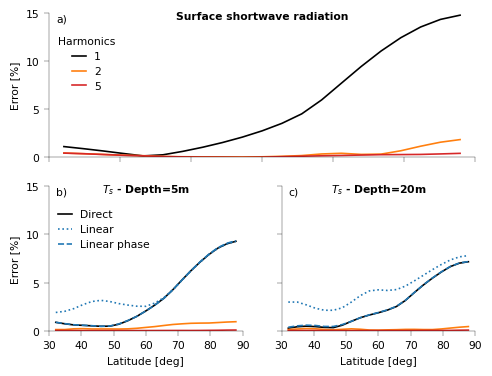

In [9]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
fig_resize(fig, utils.width['two_col'])
ax = ax.flatten()
ax[1].remove()
ax = np.delete(ax, 1)
for i in n_harmonics.values:
    ax[0].plot(ds.lat, utils.get_error(ds.swdn_sfc, sw_fourier_fit.sel(n_harmonics=i)).isel(depth=0),
               color=style_map_approx[f"direct{i}"][0], label=i)
for j in range(ds.depth.size):
    ax[j + 1].set_title(f"$T_s$ - Depth={ds.depth.values[j]:.0f}m", fontweight='bold', y=0.9)
    for i in n_harmonics.values:
        ax[j + 1].plot(ds.lat,
                       utils.get_error(temp_anom_fit.sel(fit_method='simulated'),
                                       temp_anom_fit.sel(fit_method=f"direct{i}")).isel(depth=j),
                       color=style_map_approx[f"direct{i}"][0],
                       label=style_map_approx[f"direct{i}"][2] if i == 1 else None)
    for key in ['linear', 'linear_phase']:
        ax[j + 1].plot(ds.lat,
                       utils.get_error(temp_anom_fit.sel(fit_method='simulated'),
                                       temp_anom_fit.sel(fit_method=key)).isel(depth=j),
                       color=style_map_approx[key][0], label=style_map_approx[key][2],
                       linestyle=style_map_approx[key][1])
        # ax[j+1].plot(ds.lat,
        #    utils.get_error(surf_flux_up.net.sel(fit_method='simulated'), surf_flux_up.net.sel(fit_method=key)).isel(depth=j),
        #    color=style_map_approx[key][0], label=style_map_approx[key][2],
        #              linestyle=style_map_approx[key][1])

update_linewidth(fig, 1.5)
ax[0].legend(title='Harmonics', loc='upper left', handlelength=utils.leg_handlelength,
             bbox_to_anchor=(0, 0.9))
ax[1].legend(loc='upper left', handlelength=utils.leg_handlelength, bbox_to_anchor=(0, 0.9))
ax[0].set_ylabel(utils.label_error)
ax[1].set_ylabel(utils.label_error)
ax[1].set_xlabel(utils.label_lat)
ax[2].set_xlabel(utils.label_lat)
ax[0].set_xlim(ax_lims_lat)

# Make first axis span whole figure
pos = ax[0].get_position()  # Bbox in figure coords [0..1]
pos2 = ax[2].get_position()
ax[0].set_position([pos.x0, pos.y0, pos2.x0 - pos.x0 + pos2.width, pos.height])
label_subplots(fig, ax, pos_y=0)
ax[0].set_title("Surface shortwave radiation", fontweight='bold', y=0.9)
ax[0].set_yticks([0, 5, 10, 15])
ax[0].set_ylim(0, 15)
update_fontsize(fig, 4.5)
plt.show()
# savefig(fig)
# fig_error_sw.supxlabel('Latitude [deg]', fontsize=8, y=0.02)

## Best Possible Estimate from just single harmonic

Additional powers of temperature in the $\Gamma$ approximation e.g. $\lambda_{sq}T'^2(t)$ would lead to terms of higher order than 1 harmonic in the surface energy budget, thus these cannot be the cause of the discrepancy of the linear $\Gamma$ approximation.

Looking at the $\Gamma$ plot below, there seems to be some hysteresis, which can be explained with a single harmonic. We thus seek an approximation of $\Gamma$ of the following form with three parameters that need to be found:

$\Gamma^{\uparrow} \approx \lambda_0 + \frac{1}{2}\lambda_{phase}(T(t-\mathcal{T}/4) - T(t+\mathcal{T}/4)) +
\lambda T(t)$

The phase delay is 90 days, as this refers to a quarter of the cycle (year has 360 days). This is clear to the eye, once all non phase shifted temperature dependence has been removed.

We do this fitting for each component of $\Gamma$ individually, so we have an idea of where the phase delay is coming from.

Clearly this phase term makes up almost the entire difference to the direct fit.

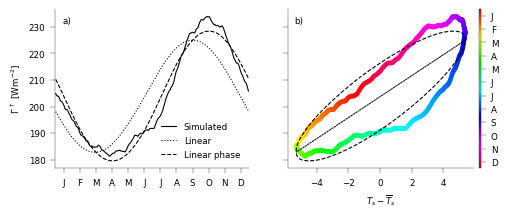

In [10]:
plot_lat_ind = 0
plot_depth_ind = -1
fig, ax = plt.subplots(1, 2, sharey=True)
fig_resize(fig, utils.width['two_col'])
for key in ['simulated', 'linear', 'linear_phase']:
    ax[0].plot(ds.time, surf_flux_up.net.isel(lat=plot_lat_ind, depth=plot_depth_ind).sel(fit_method=key), color='k',
               label=style_map_approx[key][2], linestyle=style_map_approx[key][1])
im = ax[1].scatter(temp_anom_fit.isel(lat=plot_lat_ind, depth=plot_depth_ind).sel(fit_method='simulated'),
                   surf_flux_up.net.isel(lat=plot_lat_ind, depth=plot_depth_ind).sel(fit_method='simulated'), c=ds.time,
                   cmap='hsv')
for key in ['linear', 'linear_phase']:
    ax[1].plot(temp_anom_fit.isel(lat=plot_lat_ind, depth=plot_depth_ind).sel(fit_method='simulated'),
               surf_flux_up.net.isel(lat=plot_lat_ind, depth=plot_depth_ind).sel(fit_method=key), color='k',
               linestyle=style_map_approx[key][1], label=style_map_approx[key][1])

cbar = fig.colorbar(im, ax=ax[1], aspect=100, pad=0.03, fraction=0.01)
cbar.ax.invert_yaxis()
cbar.ax.set_yticks(*utils.month_ticks)
ax[0].set_ylabel(
    '$\Gamma^{\\uparrow}$ [Wm$^{-2}$]')
ax[1].set_xlabel('$T_s - \overline{T}_s$')
# ax[1].set_xlim(-np.ceil(np.abs(t_surf_anom[plot_lat_ind]).max()), np.ceil(np.abs(t_surf_anom[plot_lat_ind]).max()))
# ax[1].set_ylim(np.floor(gamma['simulated'][plot_lat_ind].min()), np.ceil(gamma['simulated'][plot_lat_ind].max()))
update_linewidth(fig)
ax[0].legend(handlelength=utils.leg_handlelength, loc='lower right')
ax[0].set_xlim(ax_lims_time)
ax[0].set_xticks(*utils.month_ticks)
label_subplots(fig, ax)
update_fontsize(fig)
plt.show()


### Explicit effect of $\lambda_{phase}$
Below we see that the effect of non-zero $\lambda_{phase}$ is to shift the extrema later and reduce the amplitude.

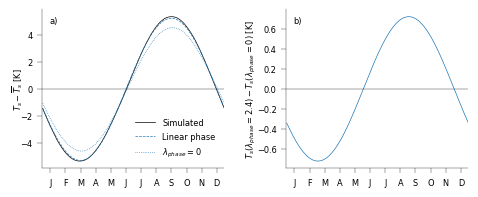

In [11]:
var = surf_flux_up_params['net'].sel(fit_method='linear_phase').isel(lat=plot_lat_ind, depth=plot_depth_ind).copy(
    deep=True)
# var.values[0] = 1.31876951
# var.values[-2] = 4.69879124
phase_param_use = var.values[0]
temp_fit_old = get_temp_fourier_analytic(ds.time.values,
                                         ds.swdn_sfc.isel(lat=plot_lat_ind, depth=plot_depth_ind).values,
                                         float(ds.heat_capacity.isel(depth=plot_depth_ind)), float(var.sel(deg='1')),
                                         phase_param_use, n_harmonics_sw=1)
temp_fit_old_numeric = get_temp_fourier_numerical(ds.time.values,
                                                  temp_anom_fit.sel(fit_method='simulated').isel(lat=plot_lat_ind,
                                                                                                 depth=plot_depth_ind).values,
                                                  surf_flux_up['net'].sel(fit_method='simulated').isel(lat=plot_lat_ind,
                                                                                                       depth=plot_depth_ind).values,
                                                  ds.swdn_sfc.isel(lat=plot_lat_ind, depth=plot_depth_ind).values,
                                                  float(ds.heat_capacity.isel(depth=plot_depth_ind)), 6,
                                                  deg_gamma_fit=8,
                                                  include_sw_phase=True, gamma_fourier_term=True)
var.values[0] = 0  # set phase coef to zero
var = utils.get_temp_fourier_analytic_xr(ds.time, ds.swdn_sfc.isel(lat=plot_lat_ind, depth=plot_depth_ind),
                                         ds.heat_capacity.isel(depth=plot_depth_ind),
                                         var, n_harmonics=1)[0]

fig, ax = plt.subplots(1, 2, sharex=True)
fig_resize(fig, utils.width['two_col'])
for key in ['simulated', 'linear_phase']:
    ax[0].plot(ds.time, temp_anom_fit.isel(lat=plot_lat_ind, depth=plot_depth_ind).sel(fit_method=key),
               color=style_map_approx[key][0], linestyle=style_map_approx[key][1], label=style_map_approx[key][2])
key = 'linear'
ax[0].plot(ds.time, var, color=style_map_approx[key][0], linestyle=style_map_approx[key][1],
           label="$\lambda_{phase}=0$")

ax[1].plot(ds.time, temp_anom_fit.isel(lat=plot_lat_ind, depth=plot_depth_ind).sel(fit_method='linear_phase') - var,
           color="C0")

ax[0].set_xlim(ax_lims_time)
ax[0].set_xticks(*utils.month_ticks)
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[1].set_ylim(-np.abs(ax[1].get_ylim()).max(), np.abs(ax[1].get_ylim()).max())
ax[0].set_ylabel('$T_s - \overline{T}_s$ [K]', labelpad=-3)
ax[0].legend()
# var = surf_flux_up_params
ax[1].set_ylabel(
    f'$T_s(\lambda_{"{phase}"}={phase_param_use:.2g}) - T_s(\lambda_{"{phase}"}= 0)$ [K]', labelpad=-1)
plt.subplots_adjust(wspace=0.34)
label_subplots(fig, ax)
update_fontsize(fig)
plt.show()
# savefig(fig)

### Extrema
Show that 1 harmonic cannot capture differing minima and maxima. Also, that linear phase basically perfectly matches the direct fit; much better than linear anyway.

In [12]:
# Record phase of maxima / minima relative to extrema times of 1st harmonic of SW radiation
time_extrema_sw = {'min': int(ds.time[0]), 'max': int(ds.time[int(ds.time.size / 2)])}

# Initialize ds_extrema
ds_extrema = xr.Dataset({key: 0 * sw_fourier_fit.isel(time=0, n_harmonics=0).expand_dims({'fit_method': fit_method})
                         for key in ['time_min', 'time_max', 'amp_min', 'amp_max']})

# Add extrema diagnostics to simulated and approximations so far
for key in ds_extrema.fit_method.values:
    ds_extrema = utils.update_ds_extrema(ds_extrema, ds.time, temp_anom_fit.sel(fit_method=key), key)

6.290584415584415

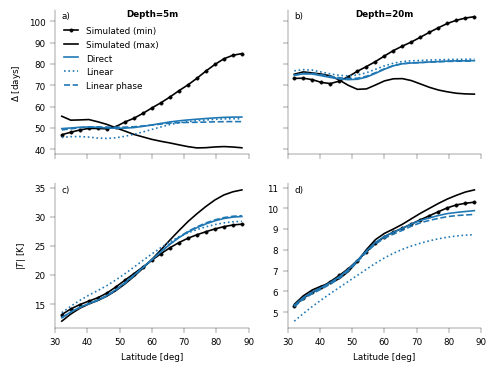

In [13]:
fig, ax = plt.subplots(2, 2, sharex=True)
fig_resize(fig, utils.width['two_col'])
for j in range(ds.depth.size):
    ax[0, j].set_title(f"Depth={ds.depth.values[j]:.0f}m", fontweight='bold', y=0.9)
    ax[1, j].set_xlabel(utils.label_lat)
    for key2 in ['simulated', 'direct1', 'linear', 'linear_phase']:
        for key in time_extrema_sw:
            if (key == 'min') and (key2 != 'simulated'):
                continue
            color_use = style_map_approx['linear'][0] if 'direct' in key2 else style_map_approx[key2][0]
            if key2 == 'simulated':
                label_use = f'Simulated ({key})'
            else:
                label_use = style_map_approx[key2][2]
            linestyle_use = style_map_approx[key2][1]
            ax[0, j].plot(ds.lat, ds_extrema[f"time_{key}"].isel(depth=j).sel(fit_method=key2) - time_extrema_sw[key],
                          color=color_use, linestyle=linestyle_use, label=label_use,
                          marker='.' if key == 'min' else None,
                          markersize=5)
            ax[1, j].plot(ds.lat, ds_extrema[f"amp_{key}"].isel(depth=j).sel(fit_method=key2),
                          color=color_use, linestyle=linestyle_use, label=label_use,
                          marker='.' if key == 'min' else None,
                          markersize=5)
ax[0, 0].set_ylabel(f"$\Delta$ [days]")
ax[1, 0].set_ylabel(f"$|T|$ [K]")
update_linewidth(fig, 1.5)
ax[0, 1].sharey(ax[0, 0])
ax[0, 1].tick_params(axis='y', labelleft=False)
ax[0, 0].legend(handlelength=utils.leg_handlelength, loc='upper left', bbox_to_anchor=(0, 0.95))
ax[0, 0].set_xlim(ax_lims_lat)
label_subplots(fig, ax.flatten(), pos_y=-1)
update_fontsize(fig)
# savefig(fig)
# ax[0, 0].legend()
# isca_tools.savefig(fig_extrema, f'extrema', save_if_exists=False)

## Breakdown of $\Gamma$
Below we plot how well we can approximate each contribution to $\Gamma$ using the various levels of the hierarchy. This is completely independent of our analytic solution for $T_s$. We make no assumptions about solar radiation or number of harmonics here.

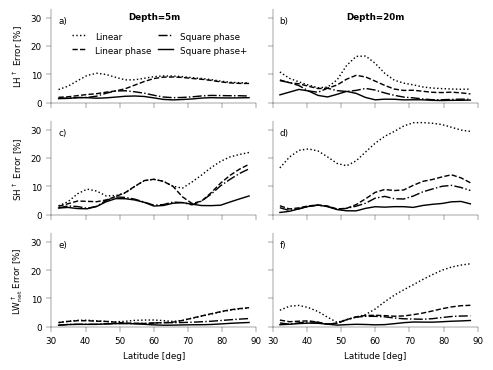

In [14]:
fig, ax = plt.subplots(3, 2, sharex=True, sharey=True)
fig_resize(fig, utils.width['two_col'], ar=2)
for j in range(ds.depth.size):
    ax[0, j].set_title(f"Depth={ds.depth.values[j]:.0f}m", fontweight='bold', y=0.8)
    ax[-1, j].set_xlabel(utils.label_lat)
    for key2 in ['linear', 'linear_phase', 'square_phase', 'square_phase+']:
        for i, key in enumerate(surf_flux_up):
            if key == 'net':
                continue
            if j == 0 and key2 == 'linear':
                ax[i, j].set_ylabel(f"{style_map_approx[key][2]} {utils.label_error}")
            ax[i, j].plot(ds.lat, utils.get_error(surf_flux_up[key].sel(fit_method='simulated'),
                                                  surf_flux_up[key].sel(fit_method=key2)).isel(depth=j),
                          color='k',
                          linestyle=style_map_approx[key2][1], label=style_map_approx[key2][2])
update_linewidth(fig, 1.3)
ax[0, 0].legend(handlelength=utils.leg_handlelength, ncol=2,
                columnspacing=0.7, loc='upper right', bbox_to_anchor=(1, 0.85))
label_subplots(fig, ax.flatten())
update_fontsize(fig)
ax[0, 0].set_xlim(ax_lims_lat)
ax[0, 0].set_ylim(0, 33)
plt.subplots_adjust(wspace=0.08)
plt.show()
# savefig(fig)

### Empirical parameters
How the empirical parameters that affect the 1 harmonic approximation vary as a function of latitude.

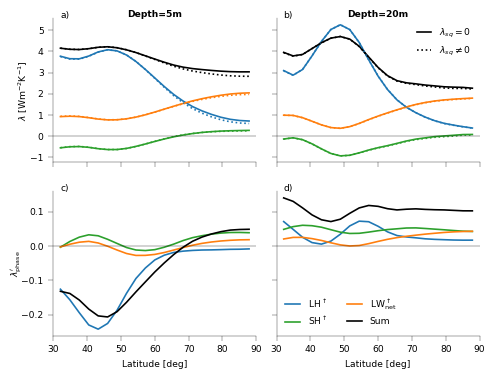

In [56]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey='row')
fig_resize(fig, utils.width['two_col'])
for j in range(ds.depth.size):
    ax[0, j].set_title(f"Depth={ds.depth.values[j]:.0f}m", fontweight='bold', y=0.95)
    ax[1, j].set_xlabel(utils.label_lat)
    for key2 in ['linear_phase', 'square_phase+']:
        for key in surf_flux_up_params:
            color_use = style_map_approx['linear'][0] if 'direct' in key2 else style_map_approx[key2][0]
            if key2 == 'simulated':
                label_use = f'Simulated ({key})'
            else:
                label_use = style_map_approx[key2][2]
            linestyle_use = style_map_approx[key2][1]
            ax[0, j].plot(ds.lat, surf_flux_up_params[key].isel(depth=j).sel(fit_method=key2, deg='1'),
                          color=style_map_approx[key][0], linestyle=':' if 'square' in key2 else None,
                          label=("$\lambda_{sq}=0$" if 'linear' in key2 else "$\lambda_{sq}\\neq0$") if key=='net' else None)
            if key2 == 'linear_phase':
                # This param always the same, so only plot for linear case
                # Use dimensionless form as for ease of interpretation
                lambda_phase_dim = get_param_dimensionless(surf_flux_up_params[key].isel(depth=j).sel(fit_method=key2, deg='phase'),
                                                           heat_capacity=ds.heat_capacity.isel(depth=j), n_year_days=ds.time.size)
                ax[1, j].plot(ds.lat, lambda_phase_dim,
                              color=style_map_approx[key][0], linestyle=':' if 'square' in key2 else None, label=style_map_approx[key][2])
update_linewidth(fig, 1.5)
ax[0, 1].legend(handlelength=utils.leg_handlelength)
ax[1, 1].legend(handlelength=utils.leg_handlelength, ncol=2)
label_subplots(fig, ax.flatten(), box_alpha=0, pos_y=5)
for ax_use in ax.flatten():
    ax_use.axhline(0, color='k', lw=ax_linewidth)
ax[0, 0].set_xlim(ax_lims_lat)
ax[0, 0].set_ylabel("$\lambda$ [Wm$^{-2}$K$^{-1}$]", labelpad=0)
ax[1, 0].set_ylabel("$\lambda_{\\text{phase}}'$", labelpad=-2)
plt.subplots_adjust(wspace=0.1)
update_fontsize(fig)
plt.show()
savefig(fig)

## Physical Interpretation of $\lambda$ and $\lambda_{phase}$
Now we try to get an idea of what sets the magnitude and latitudinal trend in $\lambda$ and $\lambda_{phase}$. We consider each flux contribution to $\lambda$ and $\lambda_{phase}$ in turn.
### Latent Heat

The [equation](https://github.com/jduffield65/Isca/blob/b9249275469583c1723f12ac62333067f9460fea/isca_source/src/coupler/surface_flux.F90#L598) used for latent heat flux by Isca is: $LH = f_{evap}L_v C_q\rho |v|(q^*(T_s, p_s) - q_{a})$

where $f_{evap}=0.1$ is the evaporative prefactor for this experiment.

So given that $q_a = r_aq^*(T_a, p_a)$; $\rho = p_a/RT_a$ where $T_a = T_s - T_{diseqb}$ and $p_a = \sigma_ap_s$, latent heat is only a function of 6 variables:

* Surface temperature, $T_s$
* Disequilibrium temperature, $T_{diseqb}$
* Relative humidity, $r_a$
* Drag coefficient $C_t$
* Wind speed, $|v|$
* Surface pressure $p_s$.

In [ ]:
def get_latent_heat(temp_surf, temp_diseqb, rh, wind_speed, drag_coef, p_surf, sigma=sigma_near_surf,
                    evap_prefactor=evap_prefactor):
    temp_a = temp_surf - temp_diseqb
    p_a = p_surf * sigma
    rho = get_density(temp_a, p_a)
    sphum_a = rh * sphum_sat(temp_a, p_a)
    return evap_prefactor * L_v * drag_coef * rho * wind_speed * (sphum_sat(temp_surf, p_surf) - sphum_a)

In [ ]:
ds_mean = ds.mean(dim='time')
lh_manual = {'all_cont': get_annual_zonal_mean(get_latent_heat(ds_base[0].t_surf, ds_base[0].temp_diseqb, ds_base[0].rh,
                                                               ds_base[0].w_atm, ds_base[0].drag_q, ds_base[0].ps)),
             'all_cont_av_first': get_latent_heat(ds.t_surf, ds.temp_diseqb, ds.rh, ds.w_atm, ds.drag_q, ds.ps),
             'mean': get_latent_heat(ds_mean.t_surf, ds_mean.temp_diseqb, ds_mean.rh, ds_mean.w_atm,
                                     ds_mean.drag_q, ds_mean.ps)}

alpha_s = clausius_clapeyron_factor(ds_mean.t_surf, ds_mean.ps)
q_sat_s = sphum_sat(ds_mean.t_surf, ds_mean.ps)
alpha_a = clausius_clapeyron_factor(ds_mean.temp, sigma_near_surf * ds_mean.ps)
q_sat_a = sphum_sat(ds_mean.temp, sigma_near_surf * ds_mean.ps)
ds_mean['rho_calc'] = get_density(ds_mean.temp, sigma_near_surf * ds_mean.ps)
lh_prefactor = evap_prefactor * L_v * ds_mean.drag_q * ds_mean.w_atm * ds_mean.rho_calc

lh_taylor = {'t_surf': -lh_manual['mean'] / ds_mean['temp'] + lh_prefactor * (
        alpha_s * q_sat_s - ds_mean.rh * alpha_a * q_sat_a),
             'temp_diseqb': lh_manual['mean'] / ds_mean['temp'] + lh_prefactor * ds_mean.rh * alpha_a * q_sat_a,
             'rh': -lh_prefactor * q_sat_a}
for key in ['w_atm', 'drag_q', 'ps']:
    lh_taylor[key] = lh_manual['mean'] / ds_mean[key]
lh_taylor['sum'] = 0
for key in lh_taylor:
    if key == 'sum':
        continue
    lh_taylor['sum'] += (lh_taylor[key] * (ds[key] - ds_mean[key]))
lh_taylor['sum'] = lh_taylor['sum'] + lh_manual['mean']
lh_taylor['t_surf_square'] = -lh_taylor['t_surf'] / ds_mean.temp + lh_manual[
    'mean'] / ds_mean.temp ** 2 + lh_prefactor * (
                                     alpha_s * q_sat_s / ds_mean.t_surf * (
                                     alpha_s * ds_mean.t_surf - 2) - ds_mean.rh * alpha_a * q_sat_a / ds_mean.temp * (
                                             alpha_a * ds_mean.temp - 2)
                             )
lh_taylor['t_surf_square'] = lh_taylor['t_surf_square'] * 0.5
lh_taylor['t_surf_w_atm'] = lh_taylor['t_surf'] / ds_mean.w_atm
lh_taylor['t_surf_rh'] = -lh_prefactor * alpha_a * q_sat_a

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(2 * im_sz * width['one_col'], im_sz * width['one_col'] / ar), sharex=True,
                       sharey=True)

ax[0].plot(ds.time, smooth_func(ds.flux_lhe.isel(lat=plot_lat_ind) - ds.flux_lhe.isel(lat=plot_lat_ind).mean()),
           color='k', label='Simulated')

ax[0].plot(ds.time, smooth_func(
    lh_manual['all_cont'].isel(lat=plot_lat_ind) - lh_manual['all_cont'].isel(lat=plot_lat_ind).mean()), color='k',
           linestyle=':', label='Average After Calc')
for i in range(len(ax)):
    ax[i].plot(ds.time, smooth_func(lh_manual['all_cont_av_first'].isel(lat=plot_lat_ind) -
                                    lh_manual['all_cont_av_first'].isel(lat=plot_lat_ind).mean()), color='k',
               linestyle='--',
               label='Average Before Calc' if i == 0 else None)
    ax[i].axhline(0, color='k', lw=ax_linewidth)
ax[0].plot(ds.time, gamma_comp['lh']['linear'][plot_lat_ind] - gamma_comp['lh']['linear'][plot_lat_ind].mean(),
           color=default_colors[0],
           label='Linear $T_s$')

for i, key in enumerate(['w_atm', 'temp_diseqb', 'drag_q', 't_surf', 'ps', 'rh']):
    ax[1].plot(ds.time, smooth_func((lh_taylor[key] * (ds[key] - ds_mean[key])).isel(lat=plot_lat_ind)), label=key,
               color=color_var[key])
ax[1].plot(ds.time,
           smooth_func((lh_taylor['t_surf_square'] * (ds['t_surf'] - ds_mean['t_surf']) ** 2).isel(lat=plot_lat_ind)),
           label='t_surf_square', color=color_var['t_surf'], linestyle=':')
if is_wishe:
    ax[1].plot(ds.time,
               smooth_func((lh_taylor['t_surf_w_atm'] * (ds['t_surf'] - ds_mean['t_surf']) * (
                       ds['w_atm'] - ds_mean['w_atm'])).isel(lat=plot_lat_ind)),
               label='t_surf_w_atm', color=color_var['w_atm'], linestyle=':')
else:
    ax[1].plot(ds.time,
               smooth_func(
                   (lh_taylor['t_surf_rh'] * (ds['t_surf'] - ds_mean['t_surf']) * (ds['rh'] - ds_mean['rh'])).isel(
                       lat=plot_lat_ind)),
               label='t_surf_rh', color=color_var['rh'], linestyle=':')
ax[1].plot(ds.time,
           smooth_func(lh_taylor['sum'].isel(lat=plot_lat_ind) - lh_taylor['sum'].isel(lat=plot_lat_ind).mean()),
           color='k', linestyle=':', label='linear sum')
ax[0].legend()
ax[1].legend(ncol=2, fontsize=6)

ax[0].set_xlim(-1, 360)
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('$LH$ Anomaly [Wm$^{-2}$]')
fig.suptitle(f"Lat = ${ds.lat[plot_lat_ind]:.0f}\degree$", fontsize=9, y=0.93);

### Sensible Heat
The equation for sensible heat is: $SH = c_p C_t\rho |v|\bigg(T_s - T_a\big(\frac{p_s}{p_a}\big)^{\kappa}\bigg)$

So given that $\rho = p_a/RT_a$ where $T_a = T_s - T_{diseqb}$ and $p_a = \sigma_ap_s$, sensible heat is only a function of 5 variables:

* Surface temperature, $T_s$
* Disequilibrium temperature, $T_{diseqb}$
* Drag coefficient $C_t$
* Wind speed, $|v|$
* Surface pressure $p_s$.

Below we investigate the relative contribution of each of these factors in a taylor series expansion.

In [ ]:
def get_sensible_heat(temp_surf, temp_diseqb, wind_speed, drag_coef, p_surf=None, density=None, sigma=sigma_near_surf):
    temp_a = temp_surf - temp_diseqb
    if density is None:
        if p_surf is None:
            raise ValueError('If density not given; surface pressure required')
        p_a = p_surf * sigma
        density = get_density(temp_a, p_a)
    return c_p * drag_coef * density * wind_speed * (temp_surf - temp_a * (1 / sigma) ** kappa)

In [ ]:
sh_manual = {
    'all_cont': get_annual_zonal_mean(get_sensible_heat(ds_base[0].t_surf, ds_base[0].temp_diseqb, ds_base[0].w_atm,
                                                        ds_base[0].drag_q, ds_base[0].ps)),
    'all_cont_av_first': get_sensible_heat(ds.t_surf, ds.temp_diseqb, ds.w_atm, ds.drag_q, ds.ps),
    'mean': get_sensible_heat(ds_mean.t_surf, ds_mean.temp_diseqb, ds_mean.w_atm,
                              ds_mean.drag_q, ds_mean.ps)}
sh_prefactor = c_p * ds_mean.drag_q * ds_mean.w_atm * get_density(ds_mean.temp, sigma_near_surf * ds_mean.ps)
sh_taylor = {'t_surf': sh_prefactor * (1 - sigma_near_surf ** kappa - (1 / ds_mean.temp) * (
        ds_mean.t_surf - sigma_near_surf ** kappa * ds_mean.temp)),
             'temp_diseqb': sh_prefactor * (sigma_near_surf ** kappa + (1 / ds_mean.temp) * (
                     ds_mean.t_surf - sigma_near_surf ** kappa * ds_mean.temp))}
for key in ['w_atm', 'drag_q', 'ps']:
    sh_taylor[key] = sh_manual['mean'] / ds_mean[key]
sh_taylor['sum'] = 0
for key in sh_taylor:
    if key == 'sum':
        continue
    sh_taylor['sum'] += (sh_taylor[key] * (ds[key] - ds_mean[key]))
sh_taylor['sum'] = sh_taylor['sum'] + sh_manual['mean']
# temp_diseqb has the largest influence so consider non-linear terms involving it
sh_taylor['temp_diseqb_w_atm'] = sh_taylor['temp_diseqb'] / ds_mean.w_atm
sh_taylor['temp_diseqb_drag_q'] = sh_taylor['temp_diseqb'] / ds_mean.drag_q
sh_taylor['w_atm_drag_q'] = sh_taylor['w_atm'] / ds_mean.drag_q
sh_taylor['w_atm_t_surf'] = sh_taylor['t_surf'] / ds_mean.w_atm
sh_taylor['temp_diseqb_square'] = sh_prefactor * (
        (ds_mean.t_surf - sigma_near_surf ** kappa * ds_mean.temp) / ds_mean.temp ** 2
        + sigma_near_surf ** kappa / ds_mean.temp)  # very small effect - just from density term
sh_taylor['temp_diseqb_square'] = sh_taylor['temp_diseqb_square'] * 0.5
sh_taylor['temp_diseqb_t_surf'] = sh_prefactor * (
        -(ds_mean.t_surf - sigma_near_surf ** kappa * ds_mean.temp) / ds_mean.temp ** 2
        + (1 - sigma_near_surf ** kappa) / ds_mean.temp)  # very small effect - just from density term

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(2 * im_sz * width['one_col'], im_sz * width['one_col'] / ar), sharex=True,
                       sharey=True)
ax[0].plot(ds.time, smooth_func(ds.flux_t.isel(lat=plot_lat_ind) - ds.flux_t.isel(lat=plot_lat_ind).mean()), color='k',
           label='Simulated')

ax[0].plot(ds.time, smooth_func(
    sh_manual['all_cont'].isel(lat=plot_lat_ind) - sh_manual['all_cont'].isel(lat=plot_lat_ind).mean()), color='k',
           linestyle=':', label='Average After Calc')
ax[0].plot(ds.time, smooth_func(sh_manual['all_cont_av_first'].isel(lat=plot_lat_ind) -
                                sh_manual['all_cont_av_first'].isel(lat=plot_lat_ind).mean()), color='k',
           linestyle='--',
           label='Average Before Calc')
ax[0].plot(ds.time, gamma_comp['sh']['linear'][plot_lat_ind] - gamma_comp['sh']['linear'][plot_lat_ind].mean(),
           color=default_colors[0],
           label='Linear $T_s$')
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[0].legend()

ax[1].plot(ds.time, smooth_func(sh_manual['all_cont_av_first'].isel(lat=plot_lat_ind) -
                                sh_manual['all_cont_av_first'].isel(lat=plot_lat_ind).mean()), color='k',
           linestyle='--')
for key in ['w_atm', 'temp_diseqb', 'drag_q', 't_surf', 'ps']:
    ax[1].plot(ds.time, smooth_func((sh_taylor[key] * (ds[key] - ds_mean[key])).isel(lat=plot_lat_ind)), label=key,
               color=color_var[key])
if is_wishe:
    ax[1].plot(ds.time,
               smooth_func((sh_taylor['temp_diseqb_w_atm'] * (ds['temp_diseqb'] - ds_mean['temp_diseqb']) *
                            (ds['w_atm'] - ds_mean['w_atm'])).isel(lat=plot_lat_ind)),
               label='temp_diseqb_w_atm', color=color_var['temp_diseqb'], linestyle=':')
    ax[1].plot(ds.time,
               smooth_func((sh_taylor['temp_diseqb_drag_q'] * (ds['temp_diseqb'] - ds_mean['temp_diseqb']) *
                            (ds['drag_q'] - ds_mean['drag_q'])).isel(lat=plot_lat_ind)),
               label='temp_diseqb_drag_q', color=color_var['drag_q'], linestyle=':')
ax[1].plot(ds.time,
           smooth_func(sh_taylor['sum'].isel(lat=plot_lat_ind) - sh_taylor['sum'].isel(lat=plot_lat_ind).mean()),
           color=color_var['sum'], linestyle=':', label='linear sum')
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[1].legend(ncol=2, fontsize=6)

ax[0].set_xlim(-1, 360)
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('$SH$ Anomaly [Wm$^{-2}$]')
fig.suptitle(f"Lat = ${ds.lat[plot_lat_ind]:.0f}\degree$", fontsize=9, y=0.93);

### Longwave
#### Emission factor, $\epsilon$
If we say that the longwave emission is given by $\sigma \epsilon T_{a}^4(t)$, this gives an equation for $\epsilon(t) = \frac{LW^{\downarrow}}{\sigma T_a^4}$.

**Seasonal variation in $\epsilon$ is due to lapse rate varying throughout the year.**

In general, $\epsilon$, is a function of optical depth of the atmosphere, as well as atmospheric temperature. This is because $LW^{\downarrow}$ is equal to the radiation reaching the bottom atmospheric level (function of atmospheric temperature and optical depth of upper atmosphere) minus amount absorbed by the bottom atmospheric level (function of optical depth of single level) plus amount emitted by bottom atmospheric level (optical thickness of bottom level multiplied by $\sigma T^4$). 

We see that $\epsilon$ is largest when surface temperature is smallest. This makes sense from Henry 2021b, because in the winter, the lower atmosphere is warmer than the surface, hence emission temperature should be closer to the surface. In the summer however, surface is warmer than the atmosphere and so expect small emission temperature.

The hysteresis is much clearer here, I think it arises due to the advective component. In April and May, sun is moving towards higher latitudes, so pole is colder than surroundings, and thus you advect warmer air from the south increasing the low level atmospheric temperature resulting in a large $\epsilon$. In December and January, sun is moving south so now less of a temperature gradient to the south and low level atmospheric temperature is not increased much by advection, resulting in small $\epsilon$.

This hysteresis is not apparent in the summer because the summer is in radiative-convective equilibrium.

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(2 * 1.5 * width['one_col'], 1.5 * width['one_col'] / ar), sharey=True)
ax[0].plot(ds.time, smooth_func(ds.emission_factor[:, plot_lat_ind]), color='k')
im = ax[1].scatter(smooth_func(t_surf_anom[plot_lat_ind]), smooth_func(ds.emission_factor[:, plot_lat_ind]), c=ds.time,
                   cmap='hsv')
ax[0].set_xlim(-1, 360)
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), aspect=100, pad=0.03, fraction=0.01)
cbar.ax.invert_yaxis()
cbar.ax.set_yticks(*month_ticks)
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Emission factor, $\epsilon$')
ax[1].set_xlabel('$T_s - \overline{T_s}$')
fig.suptitle(f"Lat = ${ds.lat[plot_lat_ind]:.0f}\degree$", fontsize=9, y=0.93);

#### Taylor Expansion
The equation for sensible heat is: $LW^{\uparrow}-LW^{\downarrow} = \sigma(T_s^4-\epsilon T_a^4)$

So it is only a function of 3 variables:

* Surface temperature, $T_s$
* Disequilibrium temperature, $T_{diseqb}$
* Emission factor, $\epsilon$

Below we investigate the relative contribution of each of these factors in a taylor series expansion.

In [ ]:
def get_longwave_net(temp_surf, temp_diseqb, emission_factor):
    temp_a = temp_surf - temp_diseqb
    return Stefan_Boltzmann * (temp_surf ** 4 - emission_factor * temp_a ** 4)

In [ ]:
lw_manual = {'all_cont': get_annual_zonal_mean(
    get_longwave_net(ds_base[0].t_surf, ds_base[0].temp_diseqb, ds_base[0].emission_factor)),
    'all_cont_av_first': get_longwave_net(ds.t_surf, ds.temp_diseqb, ds.emission_factor),
    'mean': get_longwave_net(ds_mean.t_surf, ds_mean.temp_diseqb, ds_mean.emission_factor)}
lw_taylor = {'t_surf': 4 * Stefan_Boltzmann * (ds_mean.t_surf ** 3 - ds_mean.emission_factor * ds_mean.temp ** 3),
             'temp_diseqb': 4 * Stefan_Boltzmann * ds_mean.emission_factor * ds_mean.temp ** 3,
             'emission_factor': -Stefan_Boltzmann * ds_mean.temp ** 4,
             'sum': 0}
for key in lw_taylor:
    if key == 'sum':
        continue
    lw_taylor['sum'] += (lw_taylor[key] * (ds[key] - ds_mean[key]))
lw_taylor['sum'] = lw_taylor['sum'] + lw_manual['mean']
# temp_diseqb has the largest influence so consider non-linear terms involving it
lw_taylor['t_surf_square'] = 12 * Stefan_Boltzmann * (ds_mean.t_surf ** 2 - ds_mean.emission_factor * ds_mean.temp ** 2)
lw_taylor['t_surf_square'] = lw_taylor['t_surf_square'] * 0.5
lw_taylor['t_surf_temp_diseqb'] = 12 * Stefan_Boltzmann * ds_mean.emission_factor * ds_mean.temp ** 2

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(2 * im_sz * width['one_col'], im_sz * width['one_col'] / ar), sharex=True,
                       sharey=True)
ax[0].plot(ds.time, smooth_func(ds.lw_net.isel(lat=plot_lat_ind) - ds.lw_net.isel(lat=plot_lat_ind).mean()), color='k',
           label='Simulated')

ax[0].plot(ds.time, smooth_func(
    lw_manual['all_cont'].isel(lat=plot_lat_ind) - lw_manual['all_cont'].isel(lat=plot_lat_ind).mean()), color='k',
           linestyle=':', label='Average After Calc')
ax[0].plot(ds.time, smooth_func(lw_manual['all_cont_av_first'].isel(lat=plot_lat_ind) -
                                lw_manual['all_cont_av_first'].isel(lat=plot_lat_ind).mean()), color='k',
           linestyle='--',
           label='Average Before Calc')
ax[0].plot(ds.time, gamma_comp['lw']['linear'][plot_lat_ind] - gamma_comp['lw']['linear'][plot_lat_ind].mean(),
           color=default_colors[0],
           label='Linear $T_s$')
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[0].legend()

ax[1].plot(ds.time, smooth_func(lw_manual['all_cont_av_first'].isel(lat=plot_lat_ind) -
                                lw_manual['all_cont_av_first'].isel(lat=plot_lat_ind).mean()), color='k',
           linestyle='--')
for key in ['t_surf', 'temp_diseqb', 'emission_factor']:
    ax[1].plot(ds.time, smooth_func((lw_taylor[key] * (ds[key] - ds_mean[key])).isel(lat=plot_lat_ind)), label=key,
               color=color_var[key])
ax[1].plot(ds.time,
           smooth_func((lw_taylor['t_surf_square'] * (ds['t_surf'] - ds_mean['t_surf']) ** 2).isel(lat=plot_lat_ind)),
           label='t_surf_square', color=color_var['t_surf'], linestyle=':')
ax[1].plot(ds.time,
           smooth_func((lw_taylor['t_surf_temp_diseqb'] * (ds['t_surf'] - ds_mean['t_surf']) *
                        (ds['temp_diseqb'] - ds_mean['temp_diseqb'])).isel(lat=plot_lat_ind)),
           label='t_surf_temp_diseqb', color=color_var['temp_diseqb'], linestyle=':')
ax[1].plot(ds.time,
           smooth_func(lw_taylor['sum'].isel(lat=plot_lat_ind) - lw_taylor['sum'].isel(lat=plot_lat_ind).mean()),
           color=color_var['sum'], linestyle=':', label='linear sum')
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[1].legend(fontsize=6)

ax[0].set_xlim(-1, 360)
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('$LW^{\\uparrow} - LW^{\\downarrow}$ Anomaly [Wm$^{-2}$]')
fig.suptitle(f"Lat = ${ds.lat[plot_lat_ind]:.0f}\degree$", fontsize=9, y=0.93);

### Relating variables to temperature
In the taylor series above, it appears that the variables other than `t_surf` have linear taylor series contributions that look similar to `t_surf`, and thus it seems we can do a polynomial fit of the other variables in terms of `t_surf` i.e. find coefficients $a$, $b$ and $b_{phase}$ such that $|v| \approx a + bT'(t) + b_{phase}T'(t-\mathcal{T}/4)$ for `w_atm`, and repeat for all 6 variables in the taylor expansions:

* Disequilibrium temperature, $T_{diseqb}$
* Relative humidity, $r_a$
* Drag coefficient $C_t$
* Wind speed, $|v|$
* Surface pressure $p_s$
* Emission factor, $\epsilon$

The fits are shown below, as well as the option to plot each variable's taylor series contribution to each flux (`show_flux_taylor=True`).

In [ ]:
var_anom_approx_params = {key: np.zeros((n_lat, 3)) for key in
                          ['rh', 'temp_diseqb', 'w_atm', 'drag_q', 'ps', 'emission_factor']}
var_anom_approx = {key: np.zeros((n_lat, n_time)) for key in var_anom_approx_params}
taylor_linear_coefs = {'lh': {key: lh_taylor[key].to_numpy() for key in lh_taylor if key in var_anom_approx},
                       'sh': {key: sh_taylor[key].to_numpy() for key in sh_taylor if key in var_anom_approx},
                       'lw': {key: lw_taylor[key].to_numpy() for key in lw_taylor if key in var_anom_approx}}
taylor_linear = {'lh': lh_taylor['sum'].to_numpy(), 'sh': sh_taylor['sum'].to_numpy(),
                 'lw': lw_taylor['sum'].to_numpy()}
gamma_comp_taylor_approx_params = {
    'lh': {key: np.zeros((n_lat, 2)) for key in ['rh', 'temp_diseqb', 'w_atm', 'drag_q', 'ps']},
    'sh': {key: np.zeros((n_lat, 2)) for key in ['temp_diseqb', 'w_atm', 'drag_q', 'ps']},
    'lw': {key: np.zeros((n_lat, 2)) for key in ['temp_diseqb', 'emission_factor']}}
gamma_comp_taylor_approx = {key2: {key: np.zeros((n_lat, n_time)) for key in gamma_comp_taylor_approx_params[key2]}
                            for key2 in gamma_comp_taylor_approx_params}

for i in range(n_lat):
    for key in var_anom_approx_params:
        var_anom_approx_params[key][i] = numerical.polyfit_phase(t_surf_anom[i],
                                                                 ds[key].isel(lat=i) - ds[key].isel(lat=i).mean(), 1,
                                                                 resample=resample)
        var_anom_approx[key][i] = numerical.polyval_phase(var_anom_approx_params[key][i], t_surf_anom[i])
        for key2 in gamma_comp_taylor_approx:
            if key in gamma_comp_taylor_approx[key2]:
                gamma_comp_taylor_approx_params[key2][key][i] = taylor_linear_coefs[key2][key][i] * \
                                                                var_anom_approx_params[key][i][:2]
                # Add zero below because constant term in polyfit i.e. power 0 needs to be set to 0 as lh_taylor gives anomalies
                gamma_comp_taylor_approx[key2][key][i] = numerical.polyval_phase(
                    np.append(gamma_comp_taylor_approx_params[key2][key][i], 0),
                    t_surf_anom[i])

# for t_surf make first param 0 as no phase shift for t_surf contribution to LH
gamma_comp_taylor_approx_params['lh']['t_surf'] = np.vstack(
    (np.zeros(n_lat), lh_taylor['t_surf'].to_numpy())).transpose()
gamma_comp_taylor_approx_params['sh']['t_surf'] = np.vstack(
    (np.zeros(n_lat), sh_taylor['t_surf'].to_numpy())).transpose()
gamma_comp_taylor_approx_params['lw']['t_surf'] = np.vstack(
    (np.zeros(n_lat), lw_taylor['t_surf'].to_numpy())).transpose()
for key in gamma_comp_taylor_approx_params:
    gamma_comp_taylor_approx[key]['t_surf'] = gamma_comp_taylor_approx_params[key]['t_surf'][:, 1:] * t_surf_anom
    gamma_comp_taylor_approx_params[key]['sum'] = np.sum([gamma_comp_taylor_approx_params[key][key2] for key2 in
                                                          gamma_comp_taylor_approx_params[key]], axis=0)
    gamma_comp_taylor_approx[key]['sum'] = np.sum(
        [gamma_comp_taylor_approx[key][key2] for key2 in gamma_comp_taylor_approx[key]], axis=0)

gamma_comp_taylor_approx['lh']['sum'] = gamma_comp_taylor_approx['lh']['sum'] + lh_manual['mean'].to_numpy()[
    :, np.newaxis]
gamma_comp_taylor_approx['sh']['sum'] = gamma_comp_taylor_approx['sh']['sum'] + sh_manual['mean'].to_numpy()[
    :, np.newaxis]
gamma_comp_taylor_approx['lw']['sum'] = gamma_comp_taylor_approx['lw']['sum'] + lw_manual['mean'].to_numpy()[
    :, np.newaxis]

In [ ]:
# var_anom_approx_params = {key: np.zeros((n_lat, 3)) for key in ['rh', 'temp_diseqb', 'w_atm', 'drag_q', 'ps', 'emission_factor']}
# var_anom_approx = {key: np.zeros((n_lat, n_time)) for key in var_anom_approx_params}
# gamma_comp_taylor_approx_params = {'lh': {key: np.zeros((n_lat, 3)) for key in ['rh', 'temp_diseqb', 'w_atm', 'drag_q', 'ps']}, 
#                                    'sh': {key: np.zeros((n_lat, 3)) for key in ['temp_diseqb', 'w_atm', 'drag_q', 'ps']}, 
#                                    'lw': {key: np.zeros((n_lat, 3)) for key in ['emission_factor']}}
# gamma_comp_taylor_approx = {key2: {key: np.zeros((n_lat, n_time)) for key in gamma_comp_taylor_approx_params[key2]} 
#                             for key2 in gamma_comp_taylor_approx_params}
# lh_taylor_approx_params = {key: np.zeros((n_lat, 2)) for key in var_anom_approx_params}
# lh_taylor_approx = {key: np.zeros((n_lat, n_time)) for key in var_anom_approx_params}
# # for t_surf make first param 0 as no phase shift for t_surf contribution to LH
# lh_taylor_approx_params['t_surf'] = np.vstack((np.zeros(n_lat), lh_taylor['t_surf'].to_numpy())).transpose()
# lh_taylor_approx['t_surf'] = lh_taylor_approx_params['t_surf'][:, 1:] * t_surf_anom
# 
# for key in var_anom_approx_params:
#     for i in range(n_lat):
#         var_anom_approx_params[key][i] = numerical.polyfit_phase(t_surf_anom[i], ds[key].isel(lat=i)-ds[key].isel(lat=i).mean(), 1, ds.time.to_numpy())
#         var_anom_approx[key][i] = numerical.apply_polyfit_phase(t_surf_anom[i], var_anom_approx_params[key][i])
#         lh_taylor_approx_params[key][i] = float(lh_taylor[key][i]) * var_anom_approx_params[key][i][:2]
#         # Add zero below because constant term in polyfit i.e. power 0 needs to be set to 0 as lh_taylor gives anomalies
#         lh_taylor_approx[key][i] = numerical.apply_polyfit_phase(t_surf_anom[i], np.append(lh_taylor_approx_params[key][i], 0))
# lh_taylor_approx_params['sum'] = np.sum([lh_taylor_approx_params[key] for key in lh_taylor_approx_params], axis=0)
# lh_taylor_approx['sum'] = np.sum([lh_taylor_approx[key] for key in lh_taylor_approx], axis=0)

In [ ]:
key_flux_plot = 'lh'
ignore_var_plot = ['ps']  # variables that you don't want to plot
show_flux_taylor = True  # if True will plot linear taylor series contribution to LH, otherwise will plot the variable
var_keys_plot = [key for key in gamma_comp_taylor_approx_params[key_flux_plot] if
                 key != 't_surf' and key != 'sum' and key not in ignore_var_plot]
if len(var_keys_plot) > 3:
    fig, ax = plt.subplots(2, int(np.ceil(len(var_keys_plot) / 2)),
                           figsize=(int(np.ceil(len(var_keys_plot) / 2)) * im_sz * width['one_col'],
                                    im_sz * 2 * width['one_col'] / ar), sharex=True,
                           sharey=show_flux_taylor)
    ax = ax.flatten()
else:
    fig, ax = plt.subplots(1, len(var_keys_plot),
                           figsize=(len(var_keys_plot) * im_sz * width['one_col'], im_sz * width['one_col'] / ar),
                           sharex=True,
                           sharey=show_flux_taylor)
    if len(var_keys_plot) == 1:
        ax = [ax]
for i, key in enumerate(var_keys_plot):
    if show_flux_taylor:
        colored_line(smooth_func(t_surf_anom[plot_lat_ind]), smooth_func((taylor_linear_coefs[key_flux_plot][key] *
                                                                          (ds[key] - ds_mean[key])).isel(
            lat=plot_lat_ind)), c=ds.time,
                     ax=ax[i], cmap='hsv', label='Simulated')
        ax[i].plot(t_surf_anom[plot_lat_ind], gamma_comp_taylor_approx[key_flux_plot][key][plot_lat_ind], color='k',
                   linestyle=linestyle_approx['linear_phase'], label='linear_phase approx')
        ax[i].axhline(0, color='k', lw=ax_linewidth)
        ax[i].set_title(key)
    else:
        colored_line(smooth_func(t_surf_anom[plot_lat_ind]), smooth_func(ds[key].isel(lat=plot_lat_ind)), c=ds.time,
                     ax=ax[i], cmap='hsv', label='Simulated')
        ax[i].plot(t_surf_anom[plot_lat_ind],
                   var_anom_approx[key][plot_lat_ind] + float(ds[key].isel(lat=plot_lat_ind).mean()), color='k',
                   linestyle=linestyle_approx['linear_phase'], label='linear_phase approx')
        ax[i].set_ylabel(key + (f' {var_unit_labels[key]}' if var_unit_labels[key] is not None else ''))
ax[0].set_xlim(t_surf_anom[plot_lat_ind].min(), t_surf_anom[plot_lat_ind].max())
ax[0].legend()
if show_flux_taylor:
    fig.supylabel(
        f'${key_flux_plot.upper()} - \overline{"{" + key_flux_plot.upper() + "}"}$ Contribution ' + '[Wm$^{-2}$]',
        fontsize=9, x=0.07)
fig.supxlabel('$T_s - \overline{T_s}$', fontsize=9, y=0.05)
cbar = fig.colorbar(im, ax=ax.ravel().tolist() if len(ax) > 1 else ax[0], aspect=100, pad=0.03, fraction=0.01)
cbar.ax.invert_yaxis()
cbar.ax.set_yticks(*month_ticks)
fig.suptitle(f"Lat = ${ds.lat[plot_lat_ind]:.0f}\degree$", fontsize=9, y=0.93);

### Breakdown of $\lambda$ and $\lambda_{phase}$
Below for a given flux, I plot the contributions from the different variables to the final $\lambda$ and $\lambda_{phase}$, assuming a linear taylor series expansion. The appropriateness of the linear taylor series approximation can be seen by how closer the sum of all linear terms (black solid line) is to the empirical fit (black dotted line).

It is clear that $\lambda$ does not just come from the `t_surf` component of the linear taylor series expansion.

In [ ]:
key_flux_plot = 'lh'
fig, ax = plt.subplots(1, 2, figsize=(im_sz * 2 * width['one_col'], im_sz * width['one_col'] / ar), sharex=True)
for i in range(len(ax)):
    # for key2 in gamma_comp_params:
    ax[i].plot(ds.lat, gamma_comp_params[key_flux_plot]['linear_phase'][:, 1 - i], color='k', label='Empirical',
               linestyle=':')
    for key in gamma_comp_taylor_approx_params[key_flux_plot]:
        if key == 't_surf' and i == 1:
            continue
        ax[i].plot(ds.lat, gamma_comp_taylor_approx_params[key_flux_plot][key][:, 1 - i], color=color_var[key],
                   label=key)
    ax[i].axhline(0, color='k', lw=ax_linewidth)
ax[0].legend(ncol=1 if key_flux_plot == 'lw' else 2, frameon=True, framealpha=1, edgecolor='white')
ax[0].set_xlim(ax_lims_lat)
ax[0].set_xlabel('Latitude [deg]')
ax[0].set_ylabel('Feedback Parameter (linear), $\lambda$ [Wm$^{-2}K^{-1}$]')
ax[1].set_ylabel('Feedback Parameter (phase), $\lambda_{phase}$ [Wm$^{-2}K^{-1}$]')
# fig.suptitle(f'{key_flux_plot.upper()}', fontsize=10, y=0.94)
# isca_tools.savefig(fig, f'{key_flux_plot}_param_breakdown', save_if_exists=False)

### Appropriateness of Interpretation
The above interpretation, relies on the taylor series involving just the linear terms being accurate. The plot below investigates how good an approximation this is. 

The dotted line shows the error in the linear taylor series, which is fairly significant for sensible heat. 

The dashed line then shows the error in the linear taylor series, assuming each variable is related to temperature anomaly through the linear_phase fitting of $\lambda T'(t) + \lambda_{phase}T'(t-\mathcal{T}/4)$.

The solid line shows the error in directly fitting $\lambda T'(t) + \lambda_{phase}T'(t-\mathcal{T}/4)$ to explain the anomaly in the flux (doesn't give us any interpretation of which variables contribute to the two constants).

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(im_sz * width['one_col'], im_sz * width['one_col'] / ar))
lines = []
for key in gamma_comp:
    lines += [ax.plot(ds.lat, error_func(
        smooth_func(gamma_comp[key]['simulated'] - gamma_comp[key]['simulated'].mean(axis=1)[:, np.newaxis]),
        gamma_comp[key]['linear_phase'] - gamma_comp[key]['linear_phase'].mean(axis=1)[:, np.newaxis], norm=False),
                      color=color_approx[key], label=key)[0]]
    lines += [ax.plot(ds.lat, error_func(
        smooth_func(gamma_comp[key]['simulated'] - gamma_comp[key]['simulated'].mean(axis=1)[:, np.newaxis]),
        smooth_func(taylor_linear[key] - taylor_linear[key].mean(axis=1)[:, np.newaxis]), norm=False),
                      color=color_approx[key],
                      linestyle=':')[0]]
    lines += [ax.plot(ds.lat, error_func(
        smooth_func(gamma_comp[key]['simulated'] - gamma_comp[key]['simulated'].mean(axis=1)[:, np.newaxis]),
        gamma_comp_taylor_approx[key]['sum'] - gamma_comp_taylor_approx[key]['sum'].mean(axis=1)[:, np.newaxis],
        norm=False), color=color_approx[key],
                      linestyle='--')[0]]

legend1 = ax.legend(handles=lines[::3], loc="upper left")
ax.add_artist(legend1)  # Add the first legend manually

# Second legend
ax.legend(handles=lines[:len(gamma_comp)], loc="lower right",
          labels=['Empirical (direct)', 'Taylor Linear', 'Empirical (taylor variables)'])
ax.set_ylabel('Error in each contribution to $\Gamma^{\\uparrow}$ [Wm$^{-2}$]')
ax.set_xlim(ax_lims_lat)
ax.set_xlabel('Latitude [deg]');

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(12, 8), sharey=True, sharex='col')
for i, key in enumerate(gamma_comp):
    ax[i, 0].plot(ds.time, smooth_func(gamma_comp[key]['simulated'][plot_lat_ind] -
                                       gamma_comp[key]['simulated'][plot_lat_ind].mean()), color='k', label='Simulated')
    im = ax[i, 1].scatter(smooth_func(t_surf_anom[plot_lat_ind]),
                          smooth_func(gamma_comp[key]['simulated'][plot_lat_ind] - gamma_comp[key]['simulated'][
                              plot_lat_ind].mean()),
                          c=ds.time, cmap='hsv')
    for j, var in enumerate([taylor_linear[key], gamma_comp_taylor_approx[key]['sum']]):
        ax[i, 0].plot(ds.time, smooth_func(var - var.mean(axis=1)[:, np.newaxis])[plot_lat_ind],
                      color='k', linestyle=':' if j == 0 else '--',
                      label='Taylor linear' if j == 0 else 'Empirical (taylor variables)')
        ax[i, 1].plot(t_surf_anom[plot_lat_ind], smooth_func(var - var.mean(axis=1)[:, np.newaxis])[plot_lat_ind],
                      color='k', linestyle=':' if j == 0 else '--')
    ax[i, 0].set_ylabel(key.upper() + ' Anomaly [Wm$^{-2}$]')
    # fit_param = optimize.curve_fit(square_func, t_surf_anom[no_conv_time_ind], var[no_conv_time_ind], [80, 3, 0])[0]
    # ax[i, 0].plot(ds.time, square_func(t_surf_anom, *fit_param), color='g', linestyle='--', label='Square fit (non convecting)')
    # ax[i, 1].plot(t_surf_anom, square_func(t_surf_anom, *fit_param), color='g', linestyle='--')
ax[0, 0].set_xlim(-1, 360)
ax[0, 1].set_xlim(t_surf_anom[plot_lat_ind].min(), t_surf_anom[plot_lat_ind].max())
ax[0, 0].legend()
ax[-1, 0].set_xticks(*month_ticks)
ax[-1, 1].set_xlabel('$T_s - \overline{T_s}$')
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), aspect=100, pad=0.03, fraction=0.01)
cbar.ax.invert_yaxis()
cbar.ax.set_yticks(*month_ticks)
fig.suptitle(f"Lat = ${ds.lat[plot_lat_ind]:.0f}\degree$", fontsize=9, y=0.93);